# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* Exited — факт ухода клиента

## Подготовка данных

**На этом этапе мы рассмотрим данные и проведем их предобработку.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe().round(2)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00,10000.00,10000.00,10000.00,9091.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,5000.50,15690940.57,650.53,38.92,5.00,76485.89,1.53,0.71,0.52,100090.24,0.2
std,2886.90,71936.19,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4
min,1.00,15565701.00,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0
25%,2500.75,15628528.25,584.00,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.0
50%,5000.50,15690738.00,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0
75%,7500.25,15753233.75,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,10000.00,15815690.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


In [5]:
df[df['Tenure'].isna()].describe().round(2)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,909.00,909.00,909.00,909.00,0.0,909.00,909.00,909.00,909.00,909.00,909.0
mean,4866.39,15689814.58,648.45,38.65,NaN,76117.34,1.53,0.71,0.51,99180.39,0.2
std,2909.60,75112.25,99.08,9.79,NaN,63105.69,0.59,0.45,0.50,56378.06,0.4
min,31.00,15565806.00,359.00,18.00,NaN,0.00,1.00,0.00,0.00,106.67,0.0
25%,2311.00,15626578.00,580.00,32.00,NaN,0.00,1.00,0.00,0.00,49872.33,0.0
50%,4887.00,15686870.00,647.00,37.00,NaN,96674.55,1.00,1.00,1.00,99444.02,0.0
75%,7306.00,15756804.00,718.00,43.00,NaN,128554.98,2.00,1.00,1.00,145759.70,0.0
max,10000.00,15815690.00,850.00,92.00,NaN,206663.75,4.00,1.00,1.00,199390.45,1.0


В базе данных 14 колонок, только одна из них -  `Tenure` - имеет пропущенные значения: 909 пропусков. В этой переменной заложена информация о том, сколько лет человек является клиентом банка. При этом, остальные данные на этих клиентов не сильно отличаются от базы данных в целом. Тем не менее, информация о длительности пользования услугами банка может иметь важное значение при построении модели, а заполнять пропуски нулями или средним/медианой через .transform() не кажется разумным. 
В данном случае мы можем себе позволить избавиться от их 909 строк. И потом изменить тип данных с _float_ на _int_.

Мы также удалим столбец `RowNumber`, так как он обозначает индекс строки, а индексы у нас и так есть. 
Столбцы `CustomerId` и `Surname` для построения модели нам тоже не нужны, их мы тоже удаляем. 

In [6]:
df = df.dropna(subset=['Tenure'])
df['Tenure'] = df['Tenure'].astype('int64')
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

И удалим полные дубликаты, если они закрались в базу. 

In [7]:
df = df.drop_duplicates()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   int64  
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 852.3+ KB


Далее для удобства работы мы переименуем столбцы с CamelCase в snake_case. Готовую функцию взяла с [stackoverflow](https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case).

In [9]:
import re

def snake_case (camel_input):
    words = re.findall(r'[A-Z]?[a-z]+|[A-Z]{2,}(?=[A-Z][a-z]|\d|\W|$)|\d+', camel_input)
    return '_'.join(map(str.lower, words))

In [10]:
old_names = df.columns.tolist()
new_names = []

for i in range(len(old_names)):
    new_name = snake_case(old_names[i])
    new_names.append(new_name)
    
df.columns = new_names

In [11]:
df.dtypes

credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

### Промежуточные выводы

Мы удалили пропуски, убрали ненужные для модели колонки и переименовали признаки в более удобный формат записи.
Можно переходить к следующему этапу.

## Исследование задачи

Для начала изучим целевой признак `exited` и посмотрим, насколько равномерно распределены значения этого признака.

In [12]:
df['exited'].value_counts(normalize=True).round(3)

0    0.796
1    0.204
Name: exited, dtype: float64

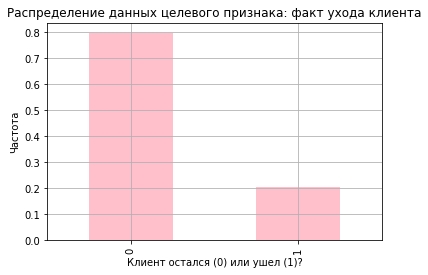

In [13]:
df['exited'].value_counts(normalize=True).plot(kind='bar', color='pink', grid=True)
plt.title('Распределение данных целевого признака: факт ухода клиента')
plt.xlabel('Клиент остался (0) или ушел (1)?')
plt.ylabel('Частота')
plt.show()

Мы видим, что данные распределены неравномерно: 80% клиентов остались, а 20% ушли. Мы примем этот факт во внимание на этапе борьбы с дисбалансом.

### Функция для ускорения работы

**Разделение данных на обучающую, валидационную и тестовую выборки в пропорциях 3:1:1, а также масштабирование количественных данных**

In [14]:
pd.options.mode.chained_assignment = None

def split_data(data):
    
    target = data['exited']
    features = data.drop('exited', axis=1)
   
    features_train, features_valid_test, target_train, target_valid_test = train_test_split(
        features, target, test_size=0.4, random_state=12345)

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid_test, target_valid_test, test_size=0.5, random_state=12345)
    
    scaler = StandardScaler()
    numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

### Пробная модель: логистическая регрессия


Два признака типа _object_ - `geography` и `gender` - мы преобразуем в числовые через OHE при помощи get_dummies() для того, чтобы мы могли обучить модель логистической регрессии. И запишем все в **`df_ohe`**.

In [15]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [16]:
df_ohe.head(2)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0


In [17]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ohe)

model_lr = LogisticRegression(solver='liblinear', random_state=12345)
model_lr.fit(features_train, target_train)
predicted_valid_lr = model_lr.predict(features_valid)
f1_score_lr = f1_score(target_valid, predicted_valid_lr)
recall_lr = recall_score(target_valid, predicted_valid_lr)
precision_lr = precision_score(target_valid, predicted_valid_lr)
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid_lr)

print('F1-мера для логистической регрессии несбалансированной выборки:', f1_score_lr.round(4))

F1-мера для логистической регрессии несбалансированной выборки: 0.304


### Пробная модель: дерево решений

Для работы с деревом решений и случайным лесом нам необходимо сначала перекодировать данные в порядковые. 

In [18]:
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df),
                            columns=df.columns)

In [19]:
features_train, 
features_valid, 
features_test, 
target_train, 
target_valid, 
target_test = split_data(df_ordinal)

best_depth_dt = 0
best_model_dt = None
best_f1_score_dt = 0


for depth in range (1, 16, 1):
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model_dt.fit(features_train, target_train)
    predicted_valid_dt = model_dt.predict(features_valid)
    f1_score_dt = f1_score(target_valid, predicted_valid_dt)
                    
    print('Глубина:', depth)
    print('F1-мера валидационной выборки:', f1_score_dt.round(4))
    print('-------')
    print()
    
    if f1_score_dt > best_f1_score_dt:
        best_model_dt = model_dt
        best_depth_dt = depth
        best_f1_score_dt = f1_score_dt
        recall_dt = recall_score(target_valid, predicted_valid_dt)
        precision_dt = precision_score(target_valid, predicted_valid_dt)
        probabilities_valid_dt = model_dt.predict_proba(features_valid)
        probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
        auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)

print()
print('Лучшая модель:', best_model_dt)
print('Глубина этой модели:', best_depth_dt)
print('F1-мера валидационной выборки этой модели:', best_f1_score_dt.round(4))

Глубина: 1
F1-мера валидационной выборки: 0.0
-------

Глубина: 2
F1-мера валидационной выборки: 0.5305
-------

Глубина: 3
F1-мера валидационной выборки: 0.3727
-------

Глубина: 4
F1-мера валидационной выборки: 0.5415
-------

Глубина: 5
F1-мера валидационной выборки: 0.5141
-------

Глубина: 6
F1-мера валидационной выборки: 0.5607
-------

Глубина: 7
F1-мера валидационной выборки: 0.5764
-------

Глубина: 8
F1-мера валидационной выборки: 0.5413
-------

Глубина: 9
F1-мера валидационной выборки: 0.5446
-------

Глубина: 10
F1-мера валидационной выборки: 0.5123
-------

Глубина: 11
F1-мера валидационной выборки: 0.5128
-------

Глубина: 12
F1-мера валидационной выборки: 0.4794
-------

Глубина: 13
F1-мера валидационной выборки: 0.4826
-------

Глубина: 14
F1-мера валидационной выборки: 0.4864
-------

Глубина: 15
F1-мера валидационной выборки: 0.4741
-------


Лучшая модель: DecisionTreeClassifier(max_depth=7, random_state=12345)
Глубина этой модели: 7
F1-мера валидационной выборки эт

### Пробная модель: случайный лес

Сначала определимся с оптимальной глубиной, а затем подберем количество деревьев. 

In [20]:
features_train, 
features_valid, 
features_test, 
target_train, 
target_valid, 
target_test = split_data(df_ordinal)

best_depth_rf = 0
best_model_rf = None
best_f1_score_rf = 0

for depth in range (1, 30):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=20)
    model_rf.fit(features_train, target_train)
    predicted_valid_rf = model_rf.predict(features_valid)
    f1_score_rf = f1_score(target_valid, predicted_valid_rf)
                    
    print('Глубина:', depth)
    print('F1-мера валидационной выборки:', f1_score_rf.round(4))
    print('-------')
    print()
    
    if f1_score_rf > best_f1_score_rf:
        best_model_rf = model_rf
        best_depth_rf = depth
        best_f1_score_rf = f1_score_rf
 
print()
print('Лучшая модель:', best_model_rf)
print('Глубина этой модели:', best_depth_rf)
print('F1-мера валидационной выборки этой модели:', best_f1_score_rf.round(4))
    

Глубина: 1
F1-мера валидационной выборки: 0.0
-------

Глубина: 2
F1-мера валидационной выборки: 0.1918
-------

Глубина: 3
F1-мера валидационной выборки: 0.2378
-------

Глубина: 4
F1-мера валидационной выборки: 0.4219
-------

Глубина: 5
F1-мера валидационной выборки: 0.5157
-------

Глубина: 6
F1-мера валидационной выборки: 0.549
-------

Глубина: 7
F1-мера валидационной выборки: 0.5651
-------

Глубина: 8
F1-мера валидационной выборки: 0.5759
-------

Глубина: 9
F1-мера валидационной выборки: 0.5502
-------

Глубина: 10
F1-мера валидационной выборки: 0.5758
-------

Глубина: 11
F1-мера валидационной выборки: 0.5729
-------

Глубина: 12
F1-мера валидационной выборки: 0.5743
-------

Глубина: 13
F1-мера валидационной выборки: 0.5657
-------

Глубина: 14
F1-мера валидационной выборки: 0.5805
-------

Глубина: 15
F1-мера валидационной выборки: 0.5846
-------

Глубина: 16
F1-мера валидационной выборки: 0.5825
-------

Глубина: 17
F1-мера валидационной выборки: 0.5846
-------

Глубина: 1

In [21]:
features_train, 
features_valid, 
features_test, 
target_train, 
target_valid, 
target_test = split_data(df_ordinal)

best_est_rf = 0
best_model_rf = None
best_f1_score_rf = 0

for est in range (10, 100, 10):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=est)
    model_rf.fit(features_train, target_train)
    predicted_valid_rf = model_rf.predict(features_valid)
    f1_score_rf = f1_score(target_valid, predicted_valid_rf)
                    
    print('Количество деревьев:', est)
    print('F1-мера валидационной выборки:', f1_score_rf.round(4))
    print('-------')
    print()
    
    if f1_score_rf > best_f1_score_rf:
        best_model_rf = model_rf
        best_est_rf = est
        best_f1_score_rf = f1_score_rf
        recall_rf = recall_score(target_valid, predicted_valid_rf)
        precision_rf = precision_score(target_valid, predicted_valid_rf)
        probabilities_valid_rf = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
        
print()
print('Лучшая модель:', best_model_rf)
print('Глубина этой модели:', best_depth_rf)
print('Количество деревьев этой модели:', best_est_rf)
print('F1-мера валидационной выборки этой модели:', best_f1_score_rf.round(4))

Количество деревьев: 10
F1-мера валидационной выборки: 0.5781
-------

Количество деревьев: 20
F1-мера валидационной выборки: 0.585
-------

Количество деревьев: 30
F1-мера валидационной выборки: 0.5919
-------

Количество деревьев: 40
F1-мера валидационной выборки: 0.5784
-------

Количество деревьев: 50
F1-мера валидационной выборки: 0.5822
-------

Количество деревьев: 60
F1-мера валидационной выборки: 0.5822
-------

Количество деревьев: 70
F1-мера валидационной выборки: 0.5752
-------

Количество деревьев: 80
F1-мера валидационной выборки: 0.5822
-------

Количество деревьев: 90
F1-мера валидационной выборки: 0.5804
-------


Лучшая модель: RandomForestClassifier(max_depth=19, n_estimators=30, random_state=12345)
Глубина этой модели: 19
Количество деревьев этой модели: 30
F1-мера валидационной выборки этой модели: 0.5919


### Пробная модель: CatBoost

In [22]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

target = df['exited']
features = df.drop('exited', axis=1) 

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

model_cb = CatBoostClassifier(n_estimators=20, max_depth=13, grow_policy='Depthwise')
cat_features = ['geography', 'gender']
model_cb.fit(features_train, target_train, cat_features=cat_features)
predicted_cb = model_cb.predict(features_test)

print()
print('=====================')
print()
print('F1-score:', f1_score(target_test, predicted_cb))
print('Recall:', recall_score(target_test, predicted_cb))
print('Precision:', precision_score(target_test, predicted_cb))
probabilities_cb = model_cb.predict_proba(features_test)
probabilities_one_cb = probabilities_cb[:, 1]
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_cb))

Learning rate set to 0.5
0:	learn: 0.5091087	total: 147ms	remaining: 2.79s
1:	learn: 0.4172111	total: 211ms	remaining: 1.9s
2:	learn: 0.3693358	total: 268ms	remaining: 1.52s
3:	learn: 0.3306617	total: 354ms	remaining: 1.42s
4:	learn: 0.3100883	total: 415ms	remaining: 1.25s
5:	learn: 0.2901415	total: 471ms	remaining: 1.1s
6:	learn: 0.2788716	total: 513ms	remaining: 952ms
7:	learn: 0.2720428	total: 551ms	remaining: 827ms
8:	learn: 0.2592149	total: 625ms	remaining: 764ms
9:	learn: 0.2523431	total: 671ms	remaining: 671ms
10:	learn: 0.2472322	total: 722ms	remaining: 591ms
11:	learn: 0.2423955	total: 766ms	remaining: 511ms
12:	learn: 0.2372596	total: 809ms	remaining: 436ms
13:	learn: 0.2327536	total: 860ms	remaining: 369ms
14:	learn: 0.2225011	total: 918ms	remaining: 306ms
15:	learn: 0.2193442	total: 965ms	remaining: 241ms
16:	learn: 0.2168606	total: 998ms	remaining: 176ms
17:	learn: 0.2152669	total: 1.03s	remaining: 115ms
18:	learn: 0.2108873	total: 1.08s	remaining: 56.8ms
19:	learn: 0.2025

In [23]:
parameters = {'n_estimators': range (10, 40, 10),
              'max_depth': range (1, 14, 2)}

grid = GridSearchCV(model_cb, parameters, cv=5)
grid.fit(features_train, target_train, cat_features=cat_features)
grid.best_params_

Learning rate set to 0.5
0:	learn: 0.5444396	total: 1.4ms	remaining: 12.6ms
1:	learn: 0.4861288	total: 3.19ms	remaining: 12.7ms
2:	learn: 0.4544598	total: 4.61ms	remaining: 10.8ms
3:	learn: 0.4358359	total: 6.04ms	remaining: 9.06ms
4:	learn: 0.4268397	total: 7.37ms	remaining: 7.37ms
5:	learn: 0.4174640	total: 8.75ms	remaining: 5.83ms
6:	learn: 0.4076927	total: 10ms	remaining: 4.29ms
7:	learn: 0.4008446	total: 11.5ms	remaining: 2.87ms
8:	learn: 0.3974187	total: 12.8ms	remaining: 1.42ms
9:	learn: 0.3926546	total: 14.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5453626	total: 1.44ms	remaining: 12.9ms
1:	learn: 0.4866796	total: 2.89ms	remaining: 11.6ms
2:	learn: 0.4550038	total: 4.2ms	remaining: 9.8ms
3:	learn: 0.4367189	total: 5.52ms	remaining: 8.28ms
4:	learn: 0.4278364	total: 6.96ms	remaining: 6.96ms
5:	learn: 0.4190074	total: 8.21ms	remaining: 5.48ms
6:	learn: 0.4104087	total: 9.65ms	remaining: 4.14ms
7:	learn: 0.4038657	total: 11ms	remaining: 2.74ms
8:	learn: 0.4004214	tota

{'max_depth': 3, 'n_estimators': 30}

In [24]:
model_cb = CatBoostClassifier(n_estimators=30, max_depth=13)
cat_features = ['geography', 'gender']
model_cb.fit(features_train, target_train, cat_features=cat_features)
predicted_cb = model_cb.predict(features_test)

print()
print('=====================')
print()
print('F1-score:', f1_score(target_test, predicted_cb))
print('Recall:', recall_score(target_test, predicted_cb))
print('Precision:', precision_score(target_test, predicted_cb))
probabilities_cb = model_cb.predict_proba(features_test)
probabilities_one_cb = probabilities_cb[:, 1]
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_cb))

Learning rate set to 0.5
0:	learn: 0.5218533	total: 48.4ms	remaining: 1.4s
1:	learn: 0.4630170	total: 143ms	remaining: 2s
2:	learn: 0.4079605	total: 240ms	remaining: 2.16s
3:	learn: 0.3780626	total: 328ms	remaining: 2.13s
4:	learn: 0.3566638	total: 418ms	remaining: 2.09s
5:	learn: 0.3403406	total: 507ms	remaining: 2.03s
6:	learn: 0.3289313	total: 510ms	remaining: 1.68s
7:	learn: 0.3181561	total: 598ms	remaining: 1.64s
8:	learn: 0.3094984	total: 602ms	remaining: 1.4s
9:	learn: 0.3023574	total: 605ms	remaining: 1.21s
10:	learn: 0.2939845	total: 694ms	remaining: 1.2s
11:	learn: 0.2863421	total: 783ms	remaining: 1.17s
12:	learn: 0.2774922	total: 873ms	remaining: 1.14s
13:	learn: 0.2717352	total: 962ms	remaining: 1.1s
14:	learn: 0.2701218	total: 966ms	remaining: 966ms
15:	learn: 0.2616497	total: 1.05s	remaining: 922ms
16:	learn: 0.2556535	total: 1.14s	remaining: 875ms
17:	learn: 0.2492032	total: 1.23s	remaining: 823ms
18:	learn: 0.2430284	total: 1.32s	remaining: 765ms
19:	learn: 0.2375126	t

### Метрики моделей

Собрем метрики трех пробных моделей в таблицу. 

In [25]:
unbalanced_metrics_dict = {
    'linear_regression': [f1_score_lr, precision_lr, recall_lr, auc_roc_lr],
    'decision_tree': [best_f1_score_dt, precision_dt, recall_dt, auc_roc_dt],
    'random_forest': [best_f1_score_rf, precision_rf, recall_rf, auc_roc_rf]
}
unbalanced_metrics_columns=['f1', 'precision', 'recall', 'auc_roc']
unbalanced_metrics = pd.DataFrame(unbalanced_metrics_dict).transpose().round(4)
unbalanced_metrics.columns = unbalanced_metrics_columns

In [26]:
unbalanced_metrics

,f1,precision,recall,auc_roc
linear_regression,0.3040,0.6179,0.2016,0.7736
decision_tree,0.5764,0.7211,0.4801,0.8346
random_forest,0.5919,0.7647,0.4828,0.8558


Мы видим, что у всех моделей проблемы с выделением положительных ответов - метрика _**recall**_ не дотягивает и до 0.5. Это значит, что модели "не попадают" и в половину всех значений 1 целевого признака. При этом, метрика _**precision**_ у модели **случайного леса** приятно выделяется со значением 0.7647: модель не так часто предсказывает 1, когда в действительности значение равно 0. 

Можно предположить, что наиболее удачная модель - **случайный лес** - лидирует по значению метрики _**F1-score**_ именно потому, что она редко предсказывает положительные ответы, и порой эти ответы совпадают с действительностью. Эта модель не разбрасывается положительными ответами, поэтому, вероятно, количество ложноположительных ответов у нее невысоко. То есть модель предсказывает не очень, но в целом лучше случайной: это можно подтвердить значением метрики _**AUC_ROC**_ в 0.85.

### Промежуточные выводы

**Мы обнаружили, что наши данные несбалансированы**: целевой признак распределен в соотношении 4:1, то есть на 4 клиента, оставющегося в банке, приходится 1, который банк покидает. 
На этой выборке мы рассмотрели модели логистической регрессии, дерева решений и случайного леса. 

**Наилучшие показатели F1-меры у модели случайного леса при глубине 19 и количестве деревьев 30.**

На следующем этапе мы постараемся улучшить все модели путем перевзвешивания классов и работой с объемом выборки. 

## Борьба с дисбалансом

### Функция для работы с моделями

Для начала напишем функцию, которая будет принимать на вход наши модели и возвращать таблицу с метриками. Это полезно, так как мы уже выделили оптимальные гиперпараметры для дерева решений и случайного леса, и теперь нам будет интересно работать с выборкой. 

In [27]:
def model_metrics (models, features_train, features_valid, target_train, target_valid):
    f1 = []
    recall = []
    precision = []
    auc_roc = []
    
    for model in models:
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1.append(f1_score(target_valid, predicted_valid))
        recall.append(recall_score(target_valid, predicted_valid))
        precision.append (precision_score(target_valid, predicted_valid))
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc.append(roc_auc_score(target_valid, probabilities_one_valid))

    index = ['f1', 'precision', 'recall', 'auc_roc']
    columns = list(models.values())
    metrics = pd.DataFrame(data=[f1, recall, precision, auc_roc], index=index, columns=columns)

    return metrics

### Перевзвешивание классов

Перевзвесим выборку так, чтобы она была сбалансирована: добавим к нашим моделям гиперпараметр _'balanced'_.  
Затем соберем сбалансированные модели в словарь и отдадим его функции _model_metrics_.

In [28]:
lr_balanced = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
dt_balanced = DecisionTreeClassifier(max_depth=7, random_state=12345, class_weight='balanced')
rf_balanced = RandomForestClassifier(max_depth=19, n_estimators=30, random_state=12345, class_weight='balanced')

models_balanced = [dt_balanced, rf_balanced]
models_balanced_name = ['decision_tree', 'random_forest']
models_balanced_dict = dict(zip(models_balanced, models_balanced_name))

lr_balanced_dict = {lr_balanced:'linear_regression'}

In [29]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ohe)
balanced_metrics_lr = model_metrics(lr_balanced_dict, features_train, features_valid, target_train, target_valid
)

features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ordinal)

balanced_metrics = model_metrics(
    models_balanced_dict, features_train, features_valid, target_train, target_valid
)

balanced_metrics = balanced_metrics.join(balanced_metrics_lr)
balanced_metrics = balanced_metrics.transpose().round(4)

In [30]:
balanced_metrics

,f1,precision,recall,auc_roc
decision_tree,0.5119,0.6870,0.4079,0.7963
random_forest,0.5563,0.4324,0.7799,0.8460
linear_regression,0.5097,0.7294,0.3917,0.7778


Видим, что перевзвешивание повысило **_F1-score_** только для **логистической регрессии**, для остальных моделей значение метрики понизилось. 

### Upsampling

Попробуем увеличить выборку через увеличение положительных целевых признаков. Мы можем увеличить их в 4 раза, чтобы добиться примерно равных долей 0 и 1. 

Сначала введем функцию **upsample**. 

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Запустим функцию и посмотрим, как изменятся метрики для разных моделей. 

In [32]:
lr_balanced = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced')
dt_balanced = DecisionTreeClassifier(max_depth=7, random_state=12345, class_weight='balanced')
rf_balanced = RandomForestClassifier(max_depth=19, n_estimators=30, random_state=12345, class_weight='balanced')

models_upsampled = [dt_balanced, rf_balanced]
models_upsampled_name = ['decision_tree', 'random_forest']
models_upsampled_dict = dict(zip(models_balanced, models_balanced_name))

lr_upsampled_dict = {lr_balanced:'linear_regression'}

In [33]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ohe)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
upsampled_metrics_lr = model_metrics(
    lr_upsampled_dict, features_upsampled, features_valid, target_upsampled, target_valid
)

features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ordinal)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
upsampled_metrics = model_metrics(
    models_upsampled_dict, features_upsampled, features_valid, target_upsampled, target_valid
)

upsampled_metrics = upsampled_metrics.join(upsampled_metrics_lr)
upsampled_metrics = upsampled_metrics.transpose().round(4)

In [34]:
upsampled_metrics

,f1,precision,recall,auc_roc
decision_tree,0.5119,0.6870,0.4079,0.7963
random_forest,0.6023,0.5464,0.6710,0.8533
linear_regression,0.5097,0.7294,0.3917,0.7778


Upsampling помог увеличить показатели для модели **случайный лес**. Теперь **_F1-score_** превысил 0.6!

### Downsampling

Теперь попробуем сделать наоборот: вместо того, чтобы увеличивать количество положительных целевых признаков мы уменьшим количество отрицательных. Все так же в 4 раза. 

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [36]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ohe)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
downsampled_metrics_lr = model_metrics(
    lr_upsampled_dict, features_downsampled, features_valid, target_downsampled, target_valid
)

features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ordinal)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
downsampled_metrics = model_metrics(
    models_upsampled_dict, features_downsampled, features_valid, target_downsampled, target_valid
)

downsampled_metrics = downsampled_metrics.join(downsampled_metrics_lr)
downsampled_metrics = downsampled_metrics.transpose().round(4)

In [37]:
downsampled_metrics

,f1,precision,recall,auc_roc
decision_tree,0.5460,0.7719,0.4224,0.8139
random_forest,0.5739,0.7878,0.4514,0.8521
linear_regression,0.5059,0.7347,0.3858,0.7769


Downsampling показал себя не таким эффективным, как upsampling. 

Попробуем вернуться к upsampling'у для самой успешной модели - **случайного леса** - и поработаем еще раз с гиперпараметрами этой модели. Может, удастся добиться более интересных результатов. 

### Изменение гиперпараметров для upsampled-модели случайного леса

In [38]:
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(df_ordinal)

features_train, target_train = upsample(features_train, target_train, 4)

best_depth_rf = 0
best_model_rf = None
best_f1_score_rf = 0

for depth in range (1, 30):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=20)
    model_rf.fit(features_train, target_train)
    predicted_valid_rf = model_rf.predict(features_valid)
    f1_score_rf = f1_score(target_valid, predicted_valid_rf)
                    
    print('Глубина:', depth)
    print('F1-мера валидационной выборки:', f1_score_rf.round(4))
    print('-------')
    print()
    
    if f1_score_rf > best_f1_score_rf:
        best_model_rf = model_rf
        best_depth_rf = depth
        best_f1_score_rf = f1_score_rf
 
print('Лучшая модель:', best_model_rf)
print('Глубина этой модели:', best_depth_rf)
print('F1-мера валидационной выборки этой модели:', best_f1_score_rf.round(4))
    

Глубина: 1
F1-мера валидационной выборки: 0.5186
-------

Глубина: 2
F1-мера валидационной выборки: 0.5671
-------

Глубина: 3
F1-мера валидационной выборки: 0.5599
-------

Глубина: 4
F1-мера валидационной выборки: 0.5691
-------

Глубина: 5
F1-мера валидационной выборки: 0.5998
-------

Глубина: 6
F1-мера валидационной выборки: 0.5857
-------

Глубина: 7
F1-мера валидационной выборки: 0.595
-------

Глубина: 8
F1-мера валидационной выборки: 0.5936
-------

Глубина: 9
F1-мера валидационной выборки: 0.5993
-------

Глубина: 10
F1-мера валидационной выборки: 0.612
-------

Глубина: 11
F1-мера валидационной выборки: 0.6047
-------

Глубина: 12
F1-мера валидационной выборки: 0.6202
-------

Глубина: 13
F1-мера валидационной выборки: 0.5995
-------

Глубина: 14
F1-мера валидационной выборки: 0.5981
-------

Глубина: 15
F1-мера валидационной выборки: 0.5869
-------

Глубина: 16
F1-мера валидационной выборки: 0.5815
-------

Глубина: 17
F1-мера валидационной выборки: 0.5991
-------

Глубина:

Сразу находим модель получше: **_F1-score_** на глубине 12 равен 0.62. Далее поэкспериментируем с количеством деревьев!

In [39]:
best_est_rf = 0
best_model_rf = None
best_f1_score_rf = 0

for est in range (10, 100, 5):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth_rf, n_estimators=est)
    model_rf.fit(features_train, target_train)
    predicted_valid_rf = model_rf.predict(features_valid)
    f1_score_rf = f1_score(target_valid, predicted_valid_rf)
                    
    print('Количество деревьев:', est)
    print('F1-мера валидационной выборки:', f1_score_rf.round(4))
    print('-------')
    print()
    
    if f1_score_rf > best_f1_score_rf:
        best_model_rf = model_rf
        best_est_rf = est
        best_f1_score_rf = f1_score_rf
        recall_rf = recall_score(target_valid, predicted_valid_rf)
        precision_rf = precision_score(target_valid, predicted_valid_rf)
        probabilities_valid_rf = model_rf.predict_proba(features_valid)
        probabilities_one_valid_rf = probabilities_valid_rf[:, 1]
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid_rf)
        
print()
print('Лучшая модель:', best_model_rf)
print('Глубина этой модели:', best_depth_rf)
print('Количество деревьев этой модели:', best_est_rf)
print('F1-мера валидационной выборки этой модели:', best_f1_score_rf.round(4))

Количество деревьев: 10
F1-мера валидационной выборки: 0.6198
-------

Количество деревьев: 15
F1-мера валидационной выборки: 0.6261
-------

Количество деревьев: 20
F1-мера валидационной выборки: 0.6202
-------

Количество деревьев: 25
F1-мера валидационной выборки: 0.6248
-------

Количество деревьев: 30
F1-мера валидационной выборки: 0.6304
-------

Количество деревьев: 35
F1-мера валидационной выборки: 0.6323
-------

Количество деревьев: 40
F1-мера валидационной выборки: 0.6261
-------

Количество деревьев: 45
F1-мера валидационной выборки: 0.6386
-------

Количество деревьев: 50
F1-мера валидационной выборки: 0.6354
-------

Количество деревьев: 55
F1-мера валидационной выборки: 0.6381
-------

Количество деревьев: 60
F1-мера валидационной выборки: 0.6347
-------

Количество деревьев: 65
F1-мера валидационной выборки: 0.6295
-------

Количество деревьев: 70
F1-мера валидационной выборки: 0.6348
-------

Количество деревьев: 75
F1-мера валидационной выборки: 0.6314
-------

Количе

Нам удалось довести **_F1-score_** до значения 0.6386! Посмотрим на остальные метрики этой модели. 

In [40]:
best_model_dict = {
    'random_forest': [best_f1_score_rf, precision_rf, recall_rf, auc_roc_rf]
}
best_model_columns=['f1', 'precision', 'recall', 'auc_roc']
best_model_metrics = pd.DataFrame(best_model_dict).transpose().round(4)
best_model_metrics.columns = best_model_columns

In [41]:
best_model_metrics

,f1,precision,recall,auc_roc
random_forest,0.6386,0.6328,0.6446,0.8611


Сравним результаты с тем, что у нас получилось до изменения гиперпараметров:

In [42]:
upsampled_metrics[1:2]

,f1,precision,recall,auc_roc
random_forest,0.6023,0.5464,0.671,0.8533


Мы видим, что значение всех метрик, кроме **_recall_**, выросло. Предположу, что уменьшение значения полноты может быть объяснено тем, что модель стала чаще предсказывать 0. 

#### Изменение гиперпараметров при помощи GridSearchCV

In [48]:
%%time

target = df_ordinal['exited']
features = df_ordinal.drop('exited', axis=1) 
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

model_rf_cv = RandomForestClassifier()
parameters_rf_cv = {'n_estimators': range (10, 50),
              'max_depth': range (1, 15)}

grid = GridSearchCV(model_rf_cv, parameters_rf_cv, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

CPU times: user 5min 53s, sys: 1.43 s, total: 5min 54s
Wall time: 5min 54s


{'max_depth': 12, 'n_estimators': 38}

In [49]:
features_train, target_train = upsample(features_train, target_train, 4)

best_model_rf_cv = RandomForestClassifier(max_depth=12, n_estimators=38, random_state=12345)
best_model_rf_cv.fit(features_train, target_train)
predicitions_rf_cv = best_model_rf_cv.predict(features_test)

f1_rf_cv = f1_score(target_test, predicitions_rf_cv)
recall_rf_cv = recall_score(target_test, predicitions_rf_cv)
precision_rf_cv = precision_score(target_test, predicitions_rf_cv)
probabilities_rf_cv = best_model_rf_cv.predict_proba(features_test)
probabilities_one_rf_cv = probabilities_rf_cv[:, 1]
auc_roc_rf_cv = roc_auc_score(target_test, probabilities_one_rf_cv)

model_rf_cv_dict = {
    'random_forest': [f1_rf_cv, precision_rf_cv, recall_rf_cv, auc_roc_rf_cv]
}
model_rf_cv_columns=['f1', 'precision', 'recall', 'auc_roc']
model_rf_cv_metrics = pd.DataFrame(model_rf_cv_dict).transpose().round(4)
model_rf_cv_metrics.columns = model_rf_cv_columns

model_rf_cv_metrics

,f1,precision,recall,auc_roc
random_forest,0.6002,0.5594,0.6475,0.8476


### Промежуточные выводы

**На этом этапе мы предприняли 3 способа борьбы с дисбалансом:**
* перевзвешивание классов
* upsampling
* downsampling

Наиболее эффективным оказался **upsampling** модели **случайный лес** с последующим изменением гиперпараметров. 
**Так наша итоговая модель имеет глубину 12 и количество деревьев 45. F1-score этой модели равен 0.6386.**	

## Тестирование модели

Здесь мы не будет работать ни с какими другими моделями, кроме той, которую мы отображи на предыдущем шаге. Проверим нашу модель на тестовой выборке. 
Для того, чтобы получше обучить нашу модель, обучим ее на чуть большей выборке, а именно разделим выборку не на три (тренировочная, валидационная, тестовая), а на две - тренировочная и тестовая. При этом используем upsampling для тренировочной выборки и будем применять все те же гиперпараметры.

In [45]:
best_model_rf

RandomForestClassifier(max_depth=12, n_estimators=45, random_state=12345)

In [46]:
target = df_ordinal['exited']
features = df_ordinal.drop('exited', axis=1) 

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train, target_train = upsample(features_train, target_train, 4)

model_test = RandomForestClassifier(max_depth=12, n_estimators=45, random_state=12345)
model_test.fit(features_train, target_train)
predicted_test = model_test.predict(features_test)
f1_score_test = f1_score(target_test, predicted_test)
recall_test = recall_score(target_test, predicted_test)
precision_test = precision_score(target_test, predicted_test)
probabilities_test = model_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)

test_model_dict = {
    'random_forest_test': [f1_score_test, precision_test, recall_test, auc_roc_test]
}
test_model_columns=['f1', 'precision', 'recall', 'auc_roc']
test_model_metrics = pd.DataFrame(test_model_dict).transpose().round(4)
test_model_metrics.columns = test_model_columns

test_model_metrics

,f1,precision,recall,auc_roc
random_forest_test,0.5998,0.562,0.643,0.6611


На тестовой выборке результаты метрики _**F1-score**_ пониже (но все же высоту в 0.59 взяли)! При этом, значение метрики **_AUC-ROC_** значительно снизилось: вероятно, за счет снижения _**precision**_.

### Промежуточные выводы

Мы протестировали модель и получили результат **_F1-score_** равный 0.5998 (ниже валидационной выборки) и значение метрики **_AUC-ROC_** 0.6611 (сильно ниже валидационной выборки).

Можно предположить, что модель рабочая, но, возможно, немного переученная. 

## Вывод

**Проект заключался в том, чтобы построить модель, способную спрогнозировать, уйдет ли клиент банка в ближайшее время или все-таки останется.**

На первом этапе мы провели **подготовку и предобработку данных**: удалили пропуски (909 строк из базы объемом в 10000 наблюдений), исключили ненужные колонки и переименовали признаки для удобства работы. 

Далее мы **построили 3 пробные модели на несбалансированных данных:**
* логистическая регрессия
* дерево решений
* случайный лес

Перебрав гиперпараметры, мы **добились модели случайного дела с метрикой F1-score в 0.5919.**

После этого, мы стали **работать над балансом данных:**
* перевзвесили классы
* сделали upsampling
* произвели downsampling

**Налучшие результаты показала модель случайного леса при upsampling'e: мы получили F1-score 0.6023 и AUC-ROC 0.8533.**

Вдохновившись этим результатом, мы решили поэкспериментировать с гиперпараметрами этой модели при upsampling'e тренировочной выборке. Как результат, **мы получили F1-score 0.6386 и AUC-ROC 0.8611.**

Далее мы проверили эту модель на тестовой выборке, предварительно обучив ее на чуть большем объеме данных (исключили валидационную выборку, она больше не нужна). 

**Финальный результат тестовой выборки оказался ниже: F1-score равный 0.5998 (ниже валидационной выборки) и значение метрики AUC-ROC 0.6611.**